<a href="https://colab.research.google.com/github/Acyuth/Stock-Price-Prediction/blob/main/StockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [3]:
ticker='TCS.NS'
df=yf.download(ticker,start='2015-01-01')

/tmp/ipython-input-3812856222.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df=yf.download(ticker,start='2015-01-01')
[*********************100%***********************]  1 of 1 completed


In [4]:
df

Price,Close,High,Low,Open,Volume
Ticker,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS
Date,,,,,
2015-01-01,988.879517,997.212261,987.111942,997.212261,366830
2015-01-02,1002.048523,1006.515971,990.841113,990.996465,925740
2015-01-05,986.820984,1009.993418,980.760752,1002.651298,1754242
2015-01-06,950.440308,982.489405,947.876342,982.489405,2423784
2015-01-07,939.213379,963.085082,935.231521,959.530584,2636332
...,...,...,...,...,...
2026-02-02,3169.600098,3198.000000,3134.000000,3198.000000,2636272
2026-02-03,3225.300049,3350.000000,3186.300049,3350.000000,4366060


<Axes: xlabel='Date'>

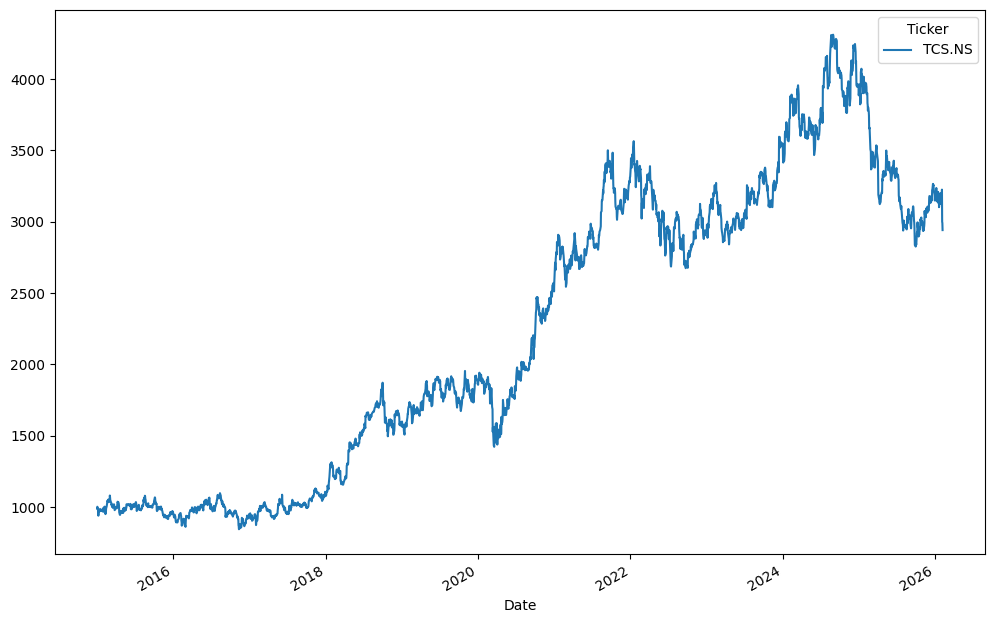

In [8]:
scaler=StandardScaler()
df['Close']=scaler.fit_transform(df['Close'])

In [10]:
df.Close

Ticker,TCS.NS
Date,
2015-01-01,-1.209541
2015-01-02,-1.196749
2015-01-05,-1.211540
2015-01-06,-1.246877
2015-01-07,-1.257782
...,...
2026-02-02,0.908622
2026-02-03,0.962724
2026-02-04,0.743013


In [11]:
seq_length = 30
data = []
for i in range(len(df)-seq_length):
    data.append(df.Close[i:i+seq_length])
data=np.array(data)


In [12]:
data

array([[[-1.20954062],
        [-1.19674939],
        [-1.2115401 ],
        ...,
        [-1.24709008],
        [-1.24000134],
        [-1.23915037]],

       [[-1.19674939],
        [-1.2115401 ],
        [-1.24687713],
        ...,
        [-1.24000134],
        [-1.23915037],
        [-1.21018925]],

       [[-1.2115401 ],
        [-1.24687713],
        [-1.25778199],
        ...,
        [-1.23915037],
        [-1.21018925],
        [-1.19277877]],

       ...,

       [[ 1.00180581],
        [ 0.98759158],
        [ 0.99617736],
        ...,
        [ 0.86423268],
        [ 0.90862188],
        [ 0.96272397]],

       [[ 0.98759158],
        [ 0.99617736],
        [ 0.95897246],
        ...,
        [ 0.90862188],
        [ 0.96272397],
        [ 0.74301299]],

       [[ 0.99617736],
        [ 0.95897246],
        [ 0.93178423],
        ...,
        [ 0.96272397],
        [ 0.74301299],
        [ 0.73563092]]])

In [13]:
train_size=int(0.8*len(data))
X_train=torch.from_numpy(data[:train_size, :-1, :])
y_train=torch.from_numpy(data[:train_size, -1, :])
X_test=torch.from_numpy(data[train_size:, -1, :])
y_test=torch.from_numpy(data[train_size:, -1, :])

In [ ]:
class PredictionModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(PredictionModel, self).__init__()
    self.num_layers=num_layers
    self.hidden_dim = hidden_dim
    self.lstm=nn.LSTM(input_dim,hidden_dim,num_layers,batch_first=True)
    self.fc=nn.Linear(hidden_dim,output_dim)

  def forward(self, x):
    h0